<a href="https://colab.research.google.com/github/asafe-eduardo/colab/blob/master/rnn_from_scratch/lstm_gru_with_tensorflow_eduardo_asafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OBJECTIVES #

Para as datas devem predizer qual são os montantes para os próximos pontos de entrada na validação e teste. E verificar em uma outra predição os pontos de melhores clientes. Lembrando que não quero a melhor predição e sim como irá ficar a arquitetura e as explicações.

### GENERAL INFO

`Account No.` - representa o número da conta envolvida na transação.

`Date` - data da transação.

`Transaction Details` - narrações de transação em extratos bancários.

`Cheque No.` - indica o número do cheque.

`Value Date` - Data de conclusão da transação.

`Withdrawal Amount` - Indica o montante retirado.

`Deposit Amount` - Indica o valor depositado.

`Balance Amount` - saldo atual da conta.



### IMPORTS

In [87]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [88]:
tf_version = tf.__version__
print(tf_version) ## 1.14

tf.reset_default_graph() ## reset graph

1.14.0


### LOAD DATA ###

In [89]:
dataframe = pd.read_excel("./bank.xlsx", Header=0, parser_dates=True)

In [90]:
dataframe.head() ## a taste of dataframe

,Account No,DATE,TRANSACTION DETAILS,CHQ.NO.,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,.
0,409000611074',2017-06-29,TRF FROM Indiaforensic SERVICES,NaN,2017-06-29,NaN,1000000.0,1000000.0,.
1,409000611074',2017-07-05,TRF FROM Indiaforensic SERVICES,NaN,2017-07-05,NaN,1000000.0,2000000.0,.
2,409000611074',2017-07-18,FDRL/INTERNAL FUND TRANSFE,NaN,2017-07-18,NaN,500000.0,2500000.0,.
3,409000611074',2017-08-01,TRF FRM Indiaforensic SERVICES,NaN,2017-08-01,NaN,3000000.0,5500000.0,.
4,409000611074',2017-08-16,FDRL/INTERNAL FUND TRANSFE,NaN,2017-08-16,NaN,500000.0,6000000.0,.


In [91]:
dataframe.info() ##print infos of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 9 columns):
Account No             116201 non-null object
DATE                   116201 non-null datetime64[ns]
TRANSACTION DETAILS    113702 non-null object
CHQ.NO.                905 non-null float64
VALUE DATE             116201 non-null datetime64[ns]
WITHDRAWAL AMT         53549 non-null float64
DEPOSIT AMT            62652 non-null float64
BALANCE AMT            116201 non-null float64
.                      116201 non-null object
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 8.0+ MB


Exist 9 columns.

total de rows = 116201

the columns `TRANSACTION DETAILS, CHQ.NO., WITHDRAWAL AMT, DEPOSIT AMT` have less rows that dataframe has so we need did do the following strategy:
    - cut off the columns with few values
    - fill the empty columns values with some value
    
but before this let's taste a flavor of values of the dataframe

In [92]:
for column in dataframe.columns:
    print('========================   PRINT VALUES ========================================')
    print('column: {0}, \nvalues: {1}'.format(column, dataframe[column].unique()[0:20]))
    print('============================= COLUMN INFO ======================================')
    print('unique values in column: {0} = {1}'.format(column, len(dataframe[column].unique())))
    print('\n\n')

========================   PRINT VALUES ========================================
column: Account No, 
values: [u"409000611074'" u"409000493201'" u"409000425051'" u"409000405747'"
 u"409000438611'" u"409000493210'" u"409000438620'" u"1196711'"
 u"1196428'" u"409000362497'"]
============================= COLUMN INFO ======================================
unique values in column: Account No = 10



========================   PRINT VALUES ========================================
column: DATE, 
values: ['2017-06-29T00:00:00.000000000' '2017-07-05T00:00:00.000000000'
 '2017-07-18T00:00:00.000000000' '2017-08-01T00:00:00.000000000'
 '2017-08-16T00:00:00.000000000' '2017-09-06T00:00:00.000000000'
 '2017-09-25T00:00:00.000000000' '2017-09-26T00:00:00.000000000'
 '2017-09-27T00:00:00.000000000' '2017-09-28T00:00:00.000000000'
 '2017-10-03T00:00:00.000000000' '2017-10-04T00:00:00.000000000'
 '2017-10-05T00:00:00.000000000' '2017-10-06T00:00:00.000000000'
 '2017-10-16T00:00:00.000000000' '2017-10-

what we discovered from values of the dataframe?
    - `Account No` have just 10 differents values the means the dataframe has just 10 account
    - `TRANSACTION DETAILS` have more of 40.000 values that means very diferents description to transactions
    - for our luck all dates have values \o/ 
    
we discovered a strange column `.` that has a unique value '.'

### PREPROCESSING ###

now we start preprocessing our dataframe, in this process we will drop and fill values that is empty to some value

In [93]:
dataframe.drop(columns=['TRANSACTION DETAILS', 'CHQ.NO.', '.'], inplace=True); ##drop columns that we not will use
for column in dataframe.columns:
    if(dataframe[column].isnull().any()):
        dataframe[column].fillna(value=dataframe[column].median(), inplace=True) ## filling our nan values with median

In [94]:
dataframe.info() ### printing now our values processed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116201 entries, 0 to 116200
Data columns (total 6 columns):
Account No        116201 non-null object
DATE              116201 non-null datetime64[ns]
VALUE DATE        116201 non-null datetime64[ns]
WITHDRAWAL AMT    116201 non-null float64
DEPOSIT AMT       116201 non-null float64
BALANCE AMT       116201 non-null float64
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 5.3+ MB


now how you can see our dataframe has all rows filled.
we removed the columns that have fews values and not means nothing for our objectives.
we filled the empty values with median that is the 'the median value of a range', we keep the `Account No` column because we need predict what client is a good client.

Our Preprocessing its not finished yet, we need now transform the `Account No` and do a couple of things. 

In [95]:
enc = OrdinalEncoder()

def categorical_to_ordinal(categorical_values, serie): ## method to convert categorical string to categorical integer
    enc.fit(categorical_values)
    serie_reshape = np.reshape(serie.to_numpy(), (-1, 1))
    return enc.transform(serie_reshape).flatten()

In [96]:
accounts_label = dataframe['Account No'].unique()
accounts = dataframe['Account No']
#accounts_ordinal = categoricalToOrdinal([[u"409000611074'"],[u"409000493201'"], [u"409000425051'"],[u"409000405747'"], [u"409000438611'"], [u"409000493210'"],[u"409000438620'"], [u"1196711'"], [u"1196428'"], [u"409000362497'"]], accounts);
accounts_ordinal = categorical_to_ordinal(accounts_label.reshape(-1,1), accounts);
dataframe['client_class'] = pd.Series(accounts_ordinal)

In [97]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt): ## method to convert timestamp in milliseconds
    return (dt - epoch).total_seconds() * 1000.0

In [98]:
dataframe['DATE'] = dataframe['DATE'].apply(unix_time_millis)
dataframe['VALUE DATE'] = dataframe['VALUE DATE'].apply(unix_time_millis)

In [99]:
def min_max_scaler(data): ## method to scaler our values
    scaler = MinMaxScaler()
    scaler.fit(data.to_numpy().reshape(-1, 1))
    transformed_data = scaler.transform(data.to_numpy().reshape(-1, 1))
    return transformed_data

In [100]:
dataframe['DATE'] = min_max_scaler(dataframe['DATE'])
dataframe['VALUE DATE'] = min_max_scaler(dataframe['VALUE DATE'])
dataframe['WITHDRAWAL AMT'] = min_max_scaler(dataframe['WITHDRAWAL AMT'])
dataframe['WITHDRAWAL AMT'] = min_max_scaler(dataframe['WITHDRAWAL AMT'])
dataframe['DEPOSIT AMT'] = min_max_scaler(dataframe['DEPOSIT AMT'])
dataframe['BALANCE AMT'] = min_max_scaler(dataframe['BALANCE AMT']); ## OMIT

we create 3 functions to transform our data:
    - `categorical_to_ordinal` we need transform the string value of `Account No` to a categorical numeric value and this method give this power to us.
    - `unix_time_millis`  a method to convert our timestamp to milliseconds(use just if our NN don't recognize timestamp value).
    - `min_max_scaler` different range of values maybe bias our model (grandient not converge to global minimum), also raise model perfomance.
    
now lets see how our dataframe stayed

In [101]:
dataframe.drop(columns=['Account No'], inplace=True); ##drop unnecessary column

In [102]:
dataframe.head()

,DATE,VALUE DATE,WITHDRAWAL AMT,DEPOSIT AMT,BALANCE AMT,client_class
0,0.597113,0.597113,0.000102,0.001836,0.996348,9.0
1,0.601050,0.601050,0.000102,0.001836,0.996835,9.0
2,0.609580,0.609580,0.000102,0.000918,0.997078,9.0
3,0.618766,0.618766,0.000102,0.005507,0.998539,9.0
4,0.628609,0.628609,0.000102,0.000918,0.998783,9.0


now is time to split our data \o/
our label will be `client_class`

In [103]:
y = dataframe.pop('WITHDRAWAL AMT') ##get client_class
X = dataframe

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## get test data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) ## get val data

In [105]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train = X_train.to_numpy().reshape(-1, 5, 1)
X_val = X_val.to_numpy().reshape(-1, 5, 1)
X_test = X_test.to_numpy().reshape(-1, 5, 1)

preprocessing done! :D

### MODEL ###

now with our data finish let's start building our model

In [106]:
## initializing our hyperparams
n_inputs = 5
n_neurons = 200
n_outputs = 1
n_layers = 2
learning_rate = 0.00001
batch_size = 128
n_epochs = 500
train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]

input_X = tf.placeholder(tf.float64, [None, n_inputs, 1])
input_y = tf.placeholder(tf.float64, [None, n_outputs])

In [107]:
index_in_epoch = 0;
perm_array = np.arange(X_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size): ## function to batch our data
    global index_in_epoch, X_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > X_train.shape[0]:
        np.random.shuffle(perm_array)
        start = 0
        index_in_epoch = batch_size
    end = index_in_epoch
    return X_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [108]:
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.relu) ## with my tests, ReLU fit better
          for layer in range(n_layers)] # 2 layer 200 neurons

multi_layer = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer, input_X, dtype=tf.float64)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_inputs, n_outputs])
outputs = outputs[:, n_inputs-1, :] 

In [109]:
loss = tf.reduce_mean(tf.square(outputs - input_y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss) # GRADIENT

In [110]:
training_loss_list = []
valid_loss_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
  
    for iteration in range(n_epochs):
        x_batch, y_batch = get_next_batch(batch_size)
        sess.run(optimizer, feed_dict={input_X: x_batch, input_y:y_batch})
        
        train_loss = loss.eval(feed_dict={input_X: X_train, input_y: y_train})
        valid_loss = loss.eval(feed_dict={input_X: X_val, input_y: y_val})
        
        training_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        
        print('Epoch {0}: train loss = {1:.10f} valid loss = {2:.10f}'.format(iteration + 1, train_loss, valid_loss))

    y_test_pred = sess.run(outputs, feed_dict={input_X: X_test})

Epoch 1: train loss = 0.0005978058 valid loss = 0.0006384102
Epoch 2: train loss = 0.0005832272 valid loss = 0.0006237945
Epoch 3: train loss = 0.0005690166 valid loss = 0.0006095469
Epoch 4: train loss = 0.0005551139 valid loss = 0.0005956084
Epoch 5: train loss = 0.0005416693 valid loss = 0.0005821274
Epoch 6: train loss = 0.0005285996 valid loss = 0.0005690203
Epoch 7: train loss = 0.0005158067 valid loss = 0.0005561891
Epoch 8: train loss = 0.0005034269 valid loss = 0.0005437708
Epoch 9: train loss = 0.0004914435 valid loss = 0.0005317482
Epoch 10: train loss = 0.0004797989 valid loss = 0.0005200637
Epoch 11: train loss = 0.0004685275 valid loss = 0.0005087520
Epoch 12: train loss = 0.0004577124 valid loss = 0.0004978970
Epoch 13: train loss = 0.0004473393 valid loss = 0.0004874844
Epoch 14: train loss = 0.0004373710 valid loss = 0.0004774762
Epoch 15: train loss = 0.0004278091 valid loss = 0.0004678739
Epoch 16: train loss = 0.0004187158 valid loss = 0.0004587407
Epoch 17: train l

Epoch 133: train loss = 0.0002762112 valid loss = 0.0003149319
Epoch 134: train loss = 0.0002762129 valid loss = 0.0003149417
Epoch 135: train loss = 0.0002762221 valid loss = 0.0003149599
Epoch 136: train loss = 0.0002762250 valid loss = 0.0003149705
Epoch 137: train loss = 0.0002762080 valid loss = 0.0003149599
Epoch 138: train loss = 0.0002761958 valid loss = 0.0003149545
Epoch 139: train loss = 0.0002761878 valid loss = 0.0003149535
Epoch 140: train loss = 0.0002761743 valid loss = 0.0003149457
Epoch 141: train loss = 0.0002761538 valid loss = 0.0003149292
Epoch 142: train loss = 0.0002761229 valid loss = 0.0003149015
Epoch 143: train loss = 0.0002761008 valid loss = 0.0003148837
Epoch 144: train loss = 0.0002760704 valid loss = 0.0003148557
Epoch 145: train loss = 0.0002760238 valid loss = 0.0003148100
Epoch 146: train loss = 0.0002759804 valid loss = 0.0003147677
Epoch 147: train loss = 0.0002759305 valid loss = 0.0003147173
Epoch 148: train loss = 0.0002758844 valid loss = 0.000

Epoch 264: train loss = 0.0002729759 valid loss = 0.0003117943
Epoch 265: train loss = 0.0002729510 valid loss = 0.0003117633
Epoch 266: train loss = 0.0002729290 valid loss = 0.0003117365
Epoch 267: train loss = 0.0002729087 valid loss = 0.0003117103
Epoch 268: train loss = 0.0002728910 valid loss = 0.0003116878
Epoch 269: train loss = 0.0002728754 valid loss = 0.0003116661
Epoch 270: train loss = 0.0002728616 valid loss = 0.0003116447
Epoch 271: train loss = 0.0002728501 valid loss = 0.0003116262
Epoch 272: train loss = 0.0002728409 valid loss = 0.0003116112
Epoch 273: train loss = 0.0002728297 valid loss = 0.0003115963
Epoch 274: train loss = 0.0002728170 valid loss = 0.0003115816
Epoch 275: train loss = 0.0002728009 valid loss = 0.0003115655
Epoch 276: train loss = 0.0002727825 valid loss = 0.0003115490
Epoch 277: train loss = 0.0002727679 valid loss = 0.0003115338
Epoch 278: train loss = 0.0002727569 valid loss = 0.0003115196
Epoch 279: train loss = 0.0002727455 valid loss = 0.000

Epoch 395: train loss = 0.0002711793 valid loss = 0.0003099399
Epoch 396: train loss = 0.0002711730 valid loss = 0.0003099297
Epoch 397: train loss = 0.0002711694 valid loss = 0.0003099215
Epoch 398: train loss = 0.0002711622 valid loss = 0.0003099115
Epoch 399: train loss = 0.0002711469 valid loss = 0.0003098970
Epoch 400: train loss = 0.0002711323 valid loss = 0.0003098826
Epoch 401: train loss = 0.0002711194 valid loss = 0.0003098689
Epoch 402: train loss = 0.0002711117 valid loss = 0.0003098582
Epoch 403: train loss = 0.0002710988 valid loss = 0.0003098434
Epoch 404: train loss = 0.0002710824 valid loss = 0.0003098263
Epoch 405: train loss = 0.0002710636 valid loss = 0.0003098081
Epoch 406: train loss = 0.0002710448 valid loss = 0.0003097914
Epoch 407: train loss = 0.0002710183 valid loss = 0.0003097707
Epoch 408: train loss = 0.0002710375 valid loss = 0.0003097781
Epoch 409: train loss = 0.0002710527 valid loss = 0.0003097846
Epoch 410: train loss = 0.0002710591 valid loss = 0.000

with our model trained its time to plot the loss for each epoch

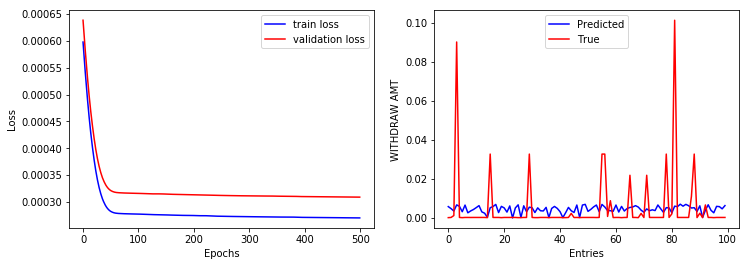

In [111]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(training_loss_list, color='blue', label='train loss')
plt.plot(valid_loss_list, color='red', label='validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(y_test_pred[0:100, -1], color='blue', label='Predicted') #its much data will printing just 100 entries
plt.plot(y_test[0:100, -1], color='red', label='True')
plt.ylabel('WITHDRAW AMT')
plt.xlabel('Entries')
plt.legend()
plt.show()

like you can see our loss is decreasing over time it is good notices for us

the predictions has been done too, so the next step is mount our data again
to visualize our result and answer the questions

In [112]:
X_test = X_test.reshape(-1, 5)
results = pd.DataFrame({'Date': X_test[:, 0],
                        'VALUE DATE': X_test[:, 1],
                        'DEPOSIT AMT': X_test[:, 2],
                        'BALANCE AMT': X_test[:, 3],
                        'client_class': X_test[:, 4],
                        'WITHDRAWAL AMT': y_test_pred.reshape(-1,)
                       })

most_withdrawal_accounts_value = results.sort_values(by='WITHDRAWAL AMT', ascending=False).iloc[0:9]

like previosly above, we transform all `Account No` in a interger value and store it in a column called `client_class` we see that the most evaluated client or with most potential client is the client with `client_class` column with value 0 but why that client is considered with most potential?

we presume that column `WITHDRAWAL AMT` its not so about a CASH WITHDRAWAL, like column `TRANSACTION DETAILS` show to us, the dataset have a resume about all transfers in the bank this means all payment, deposit etc... in resume: the client with label 0 is taking money from your account and investing in another account he is our 'BIG FISH' but, what account is the column `client_class` with value 0? its we find in follow.

In [113]:
client_class = most_withdrawal_accounts_value.iloc[0]['client_class'] ## GET CLASS OF OUR BIG FISH

for idx in range(len(accounts_label)):
    if(idx == client_class):
        print(accounts_label[idx])

409000493201'


Our BIG FISH is the client with `Account No` = `409000611074'`. 
its time to approve to her a new line of credit and give a limitless platinum card. \o/ 

### THANKS ###